In [1]:
from polymer import *
import numpy as np
import math as m
import matplotlib.pyplot as plt

In [2]:
def bin_index(x, bin_edges):

    bin_range = bin_edges[-1] - bin_edges[0]
    bin_pos = x - bin_edges[0]

    return int( (bin_pos/bin_range)*(len(bin_edges)-1.0) )

In [3]:
def run_tmmc_sweeps(chain, bin_edges, bias, trans_matrix, Nsweeps=100, max_disp=0.15, temperature=0.2, sample_int=100):
    """ Runs Nsweeps MC sweeps where one sweep is on average at attempt to move each mobile bead on the chain at least once.
        Returns a  """

    # Store inverse temperature
    beta = 1.0/temperature

    # Initialise sampling for the current set of sweeps
    samples = []
    acount  = 0

    old_energy = chain.energy()
    
    for itrial in range(Nsweeps*(chain.Nbeads-1)):

        # Randomly choose any bead but the first
        ibead = np.random.randint(1,chain.Nbeads) # first bead never moves

        disp = 2.0*np.random.random_sample(2)-1.0
        disp = disp*max_disp

        old_local_energy = chain.local_energy(ibead)
        
        ibin = bin_index(old_energy, bin_edges)
        old_bias = bias[ibin]
        
        chain.rpos[ibead] = chain.rpos[ibead] + disp
    
        new_local_energy = chain.local_energy(ibead)

        new_energy = old_energy + ( new_local_energy - old_local_energy )
        jbin = bin_index(new_energy, bin_edges)
        
        trans_matrix[ibin,ibin] += 1.0 - min(1.0, m.exp(-beta*(new_local_energy - old_local_energy)))

        if jbin in range (0, len(bias)):

            #trans_matrix[ibin,ibin] += 1.0 - min(1.0, m.exp(-beta*(new_local_energy - old_local_energy)))
            trans_matrix[jbin,ibin] += min(1.0, m.exp(-beta*(new_local_energy - old_local_energy)))
            
            new_bias = bias[jbin]
        
            diff_energy = (new_energy + new_bias) - (old_energy + old_bias)
            

            if np.random.sample() < m.exp(-diff_energy*beta):
                # accepted
                acount = acount + 1
                old_energy = new_energy
            else:
                # reject and reset
                chain.rpos[ibead] = chain.rpos[ibead] - disp

        else:
            # reject and reset
            chain.rpos[ibead] = chain.rpos[ibead] - disp
        

        if itrial%sample_int*(chain.Nbeads-1)==0:
            samples.append((chain.energy(), chain.end2end()))

    return chain, samples, trans_matrix, acount/(Nsweeps*(chain.Nbeads-1))    

In [4]:
def bias_from_tm(tm, bin_edges, bin_width, temperature):

    nstates = len(bin_edges)-1
    norm_tm = np.zeros([nstates,nstates])

    for k in range(0, nstates):
        Pnorm = np.sum(tm[:,k])
        for kk in range(0, nstates):
            if Pnorm > 0.0:
                norm_tm[kk,k] = tm[kk,k]/Pnorm


    eigvals, eigvects = np.linalg.eig(norm_tm)
    idom = np.argmax(np.real(eigvals))

    statP = np.absolute(eigvects[:,idom])

    mincount = np.min(statP[statP > 0.0])
    statP = [ max(P,mincount) for P in statP]
    statP = statP/np.sum(statP)

    new_bias = np.zeros(nstates)
    for ibin, edge in enumerate(bin_edges[0:-1]):
        bin_energy = edge + 0.5*bin_width
        new_bias[ibin] = temperature*m.log(statP[ibin])

    min_bias = np.min(new_bias)
    new_bias = [bias - min_bias for bias in new_bias]
    
    return new_bias, norm_tm, statP

Starting sampling from bin  29


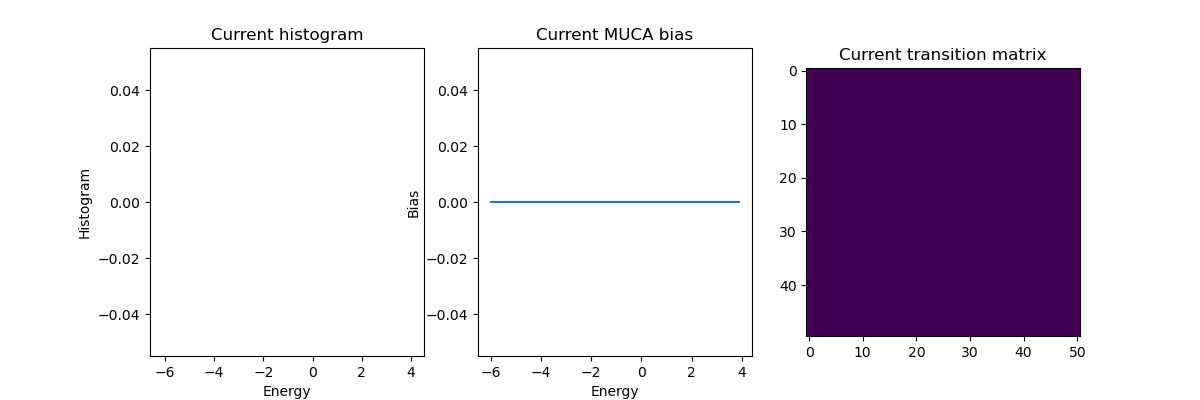

In [5]:
# Initialise TMMC simulation

Ndims=2 ; Nbeads=7
chain = polymer(Ndims = Ndims, Nbeads = Nbeads)

# Define energy range and bins
energy_range = [-6.1, 4.0]
bin_edges = np.histogram_bin_edges(energy_range, bins=50)
bin_width = bin_edges[1] - bin_edges[0]

print("Starting sampling from bin ", bin_index(chain.energy(), bin_edges))

bias = np.zeros(len(bin_edges)-1)
histogram = np.zeros(len(bin_edges)-1)
trans_matrix = np.zeros([len(bin_edges)-1,len(bin_edges)])

# Setup some plots
%matplotlib widget
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(12, 4))
ax1.bar(bin_edges[:-1], histogram,   width=bin_width,align='edge')
ax2.plot(bin_edges[:-1]+0.5*bin_width, bias)
ax3.imshow(trans_matrix)

ax1.set_xlabel('Energy')
ax2.set_xlabel('Energy')
ax1.set_ylabel('Histogram')
ax2.set_ylabel('Bias')
#fig.suptitle('MUCA weights refinement', fontsize=16)
ax1.set_title('Current histogram')
ax2.set_title('Current MUCA bias')
ax3.set_title('Current transition matrix')
plt.show()


In [7]:
from ipywidgets import IntProgress
from IPython.display import display
import time

temp = 0.4
beta = 1.0/temp

Ncycles=  50   # Bias update cycles
Nframes = 500  # Number frames per bias update cycle

n_equil_frames = 100

filename = 'data/muca_bias_N7T0.4_cycle_49.txt'
bias = np.loadtxt(filename)
initial_bias = np.copy(bias)
statP = np.zeros(len(bin_edges)-1)



for ibin in range(len(bin_edges)-1):
    statP[ibin] = m.exp(beta*initial_bias[ibin])
statP = statP/np.sum(statP)


trans_matrix = np.zeros([len(bin_edges)-1,len(bin_edges)])
norm_tm = trans_matrix

f = IntProgress(min=0, max=Nframes*Ncycles+n_equil_frames) # instantiate the bar
display(f) # display the bar

for iframe in range(n_equil_frames):
    chain, new_samples, trans_matrix, ratio = run_tmmc_sweeps(chain, bin_edges, bias, trans_matrix,  Nsweeps=100, max_disp=0.07, temperature=temp, sample_int = 100)


trans_matrix = np.zeros([len(bin_edges)-1,len(bin_edges)])
norm_tm = trans_matrix

for icyc in range(Ncycles):

    #Ndims=2 ; Nbeads=7
    #chain = polymer(Ndims = Ndims, Nbeads = Nbeads)

    samples = []
    muca_hist = np.zeros(len(bin_edges)-1)

    fig.canvas.draw()
    fig.canvas.flush_events()

    for iframe in range(Nframes):

        chain, new_samples, trans_matrix, ratio = run_tmmc_sweeps(chain, bin_edges, bias, trans_matrix,  Nsweeps=100, max_disp=0.07, temperature=temp, sample_int = 100)
        samples += new_samples
        f.value +=1  # Increment progress bar

        energy_samples  = [ sample[0] for sample in samples ]
        counts, bins = np.histogram(energy_samples, bins=bin_edges, density=True)

        # Setup some plots
        ax1.cla(), ax2.cla(); ax3.cla()
        ax1.bar(bin_edges[:-1], counts,   width=bin_width,align='edge')
        ax1.plot(bin_edges[:-1], statP)
        
        ax2.plot(bin_edges[:-1]+0.5*bin_width, bias,'o-')
        ax2.plot(bin_edges[:-1]+0.5*bin_width, initial_bias,'-')
        ax3.imshow(norm_tm)
        
        ax1.set_xlabel('Energy')
        ax2.set_xlabel('Energy')
        ax1.set_ylabel('Histogram')
        ax2.set_ylabel('Bias')
        #fig.suptitle('MUCA weights refinement', fontsize=16)
        ax1.set_title('Current histogram')
        ax2.set_title('Current MUCA bias')
        ax3.set_title('Current transition matrix')
        plt.draw()
    
        fig.canvas.draw()
        fig.canvas.flush_events()


    print("Move acceptance ratio : ",ratio)
    
    # Compute new bias weights from transition matrix
    bias, norm_tm, statP = bias_from_tm(trans_matrix, bin_edges, bin_width, temp)


IntProgress(value=0, max=25100)

Move acceptance ratio :  0.8366666666666667
Move acceptance ratio :  0.8433333333333334
Move acceptance ratio :  0.8066666666666666
Move acceptance ratio :  0.575
Move acceptance ratio :  0.7183333333333334
Move acceptance ratio :  0.5533333333333333


KeyboardInterrupt: 